<img src='./images/film_logo.jpeg' style='float:left; width:200px;height:200px'/>

#  <h1><center> Capstone Project: Film Linguistics </center></h1>
#  Notebook 3c - Support Vector Regression (SVR)
####  Stephen Strawbridge, Cohort #1019

In [22]:
#Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import from sklearn.
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import LinearSVR, SVR

In [23]:
#Read in cleaned dataset
df = pd.read_csv('./CSVs/cleaned_df.csv');

In [24]:
df = df.drop(columns='Unnamed: 0')
df.head()

,MovieID,IDSubtitleFile,IDSubtitle,MovieName,MovieYear,SubDownloadsCnt,TotalWords,HarmVirtue,HarmVirtue-ratio,HarmVice,...,Relig-ratio,Death,Death-ratio,Informal,Informal-ratio,Swear,Swear-ratio,Filler,Filler-ratio,years_old
0,6247,141146,102946,Jan Dara,2001,4094,4352,3,0.000689,10,...,0.002757,14,0.003217,67,0.015395,34,0.007813,1,0.000230,20
1,70811,1953655263,5113335,Pocahontas,1995,81,6315,8,0.001267,39,...,0.003959,25,0.003959,68,0.010768,2,0.000317,0,0.000000,26
2,38254,1952519756,3855025,Space Chimps,2008,45,7435,10,0.001345,8,...,0.002824,17,0.002286,340,0.045730,5,0.000672,62,0.008339,13
3,150,1953609111,5067084,A Bug's Life,1998,213,7932,8,0.001009,12,...,0.001009,18,0.002269,461,0.058119,8,0.001009,24,0.003026,23
4,4150,1953020828,4460230,Babe,1995,186,6176,4,0.000648,12,...,0.003400,10,0.001619,171,0.027688,5,0.000810,7,0.001133,26


## Section 1 - Create Features
---

#### Create Features for Model

In [25]:
#First create list of all ratio columns to use
ratio_cols = [col for col in df.columns if 'ratio' in col]


#Create list of all the dummified genres to include in features
genres = ['drama', 'comedy', 'romance', 'action', 'crime', 'mystery', 'western', 'animation', 'thriller',
         'biography', 'adventure', 'horror', 'fantasy', 'musical', 'war', 'sport', 'documentary', 'family',
         'short', 'music', 'history', 'adult', 'news']

#All of features to include in model
other_feats = ['years_old']

#Create features list
features = ratio_cols + genres + other_feats

#Create dataframe for features
X = df[features]

In [26]:
#Create array for target variable ('rating_rank')
y = df['rating_rank']

In [27]:
# Train-test-split data.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 42)

## Section 2 - PCA
---

#### Standardize Data (as needed in PCA)

In [28]:
# Instantiate our StandardScaler.
ss = StandardScaler()

# Standardize X_train.
X_train = ss.fit_transform(X_train)

# Standardize X_test.
X_test = ss.transform(X_test)

#### Unfortunately, PCA did not appear to improve our model.  As illustrated in the explained variance ratios above,  there were no clear principal components that held predictive value in the dataset.

## Section 3 - Support Vector Regression Model
---

In [31]:
#From these model parameters, we are going to make a dictionary to save our best parameters
#Note that we should NOT re-run this cell, unless we want to create new dataframe of parameters
# model_params = {}
# count = 0

In [32]:
# Instantiate and fit a gridsearch model for this SVR
svr = SVR()

# Create a paramaters grid
p_grid = {
    'C':np.linspace(0.5, 1.5, 20),
    'kernel':['rbf'], 
    'degree':[0.5, 1]
}

# Instantiate a GridSearch 
gssvr = GridSearchCV(estimator=svr, param_grid=p_grid, cv=5, n_jobs=4)

# Fit on training data.
gssvr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=4,
             param_grid={'C': array([0.5       , 0.55263158, 0.60526316, 0.65789474, 0.71052632,
       0.76315789, 0.81578947, 0.86842105, 0.92105263, 0.97368421,
       1.02631579, 1.07894737, 1.13157895, 1.18421053, 1.23684211,
       1.28947368, 1.34210526, 1.39473684, 1.44736842, 1.5       ]),
                         'degree': [0.5, 1], 'kernel': ['rbf']})

In [33]:
#Create dataframe of best results (best parameters and the respective score)
count += 1
gssvr.best_params_['score'] = gssvr.best_score_ 
model_params[f'model_{count}'] = gssvr.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')
model_df

,C,degree,kernel,score
model_1,0.921053,1.0,rbf,0.323780
model_2,0.921053,0.5,rbf,0.325693


In [34]:
#Save best param/score results
model_df.to_csv('./Best_Params/SVR/SVR_Jan21_params.csv')

In [35]:
#Look at R-squared scores
train_score = round(gssvr.score(X_train, y_train), 5)
test_score = round(gssvr.score(X_test, y_test), 5)

print(f'Training R-squared: {train_score}')
print(f'Testing R-squared: {test_score}')

Training R-squared: 0.53677
Testing R-squared: 0.30906


In [36]:
#Baseline RMSE (source code leveraged from https://numpy.org/doc/stable/reference/generated/numpy.zeros_like.html)
null_pred = np.zeros_like(y_test)
null_pred = null_pred + y_test.mean()
base_RMSE = round(metrics.mean_squared_error(y_test, null_pred, squared=False), 5)

print(f'Baseline RMSE: {base_RMSE}')

Baseline RMSE: 1.1321


In [37]:
#Create predictions and residuals variables
preds = gssvr.predict(X_test)
resids = y_test - preds

test_RMSE = round(metrics.mean_squared_error(y_test, preds, squared=False), 5)
print(f'Testing RMSE: {test_RMSE}')

Testing RMSE: 0.94103


In [38]:
#How much better is our testing RMSE than baseline RMSE
under_base = round(base_RMSE/test_RMSE, 4)
print(f'Model is {under_base} times better than baseline model')

Model is 1.203 times better than baseline model


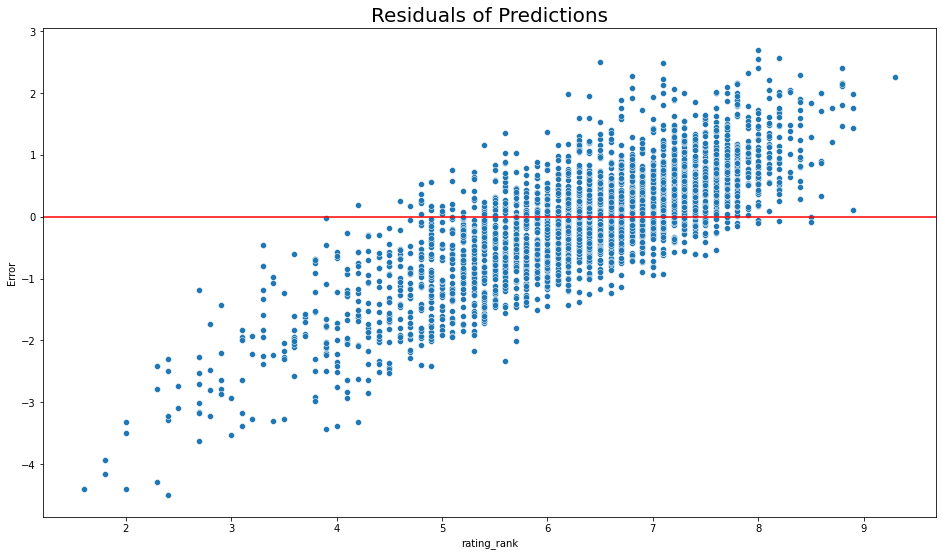

In [39]:
#Plot residuals

plt.figure(figsize=(16,9))
sns.scatterplot(x=y_test, y=resids)
plt.title('Residuals of Predictions', fontsize=20)
plt.ylabel('Error');
plt.axhline(0, color='r');

#### Interesting Note:  The residuals seem to follow a *linear* pattern.  Throughout all the data, the model seems to generally seems to underestimate very poorly ranked movies and very highly ranked movies (e.g. model gives predictions that are more closely centered around the mean).

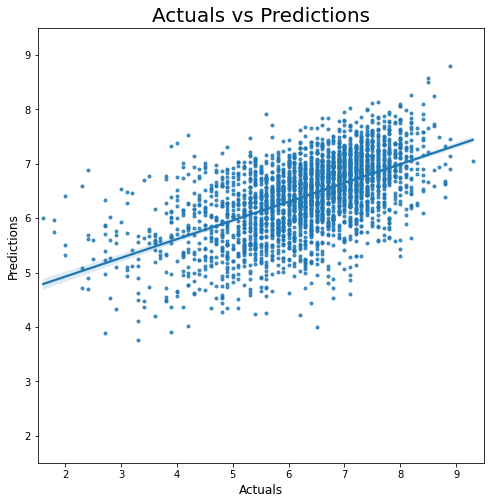

In [40]:
plt.figure(figsize=(8,8))
plt.title('Actuals vs Predictions', fontsize=20);

sns.regplot(x=y_test, y=preds, data=X_test, marker='.');

plt.xlim(1.5, 9.5)
plt.ylim(1.5, 9.5)
plt.xlabel('Actuals', fontsize=12);
plt.ylabel('Predictions', fontsize=12);

#### As seen in graph above, our predictions fall in the range of about 4 to 8.5 rating rank.  Although this is a small range as compared to the actual range, it does make sense, as the distribution of actual rating ranks is very steep (e.g. only a very small percentage of movies fall below a 4 or above an 8.5 on the rating rank).